<a href="https://colab.research.google.com/github/adhamrait/uncategorized_projects/blob/main/AM229_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display

In [ ]:
n = 64
sigma = 0.1
f = lambda x: np.sin(x*10*np.pi)
# f = lambda x: x - 1/2

X = np.linspace(0, 1, n)
Y = np.vectorize(lambda x: f(x) + np.random.normal(0, sigma))(X)
l = 0.1
kernels = [
  lambda x1, x2: (1 + (x1 - x2)**2/(2*1.1)*(l**2))**(-1.1), # Rational Quadratic kernel, l=dx, a=4
  lambda x1, x2: 1/2+(x1-1)*(x2-1), # Linear kernel, y-intercept = 1/2, x-intercept = 1
  lambda x1, x2: np.exp(-2*np.sin(np.pi*abs(x1-x2)/0.2)**2*l**2), # Pereodic kernel, l=dx1, p=0.2
  lambda x1, x2: np.exp(-(x1-x2)**2 * l**2), # Squared exponential kernel, l=dx
]
noise = np.eye(n) * sigma**2
K = np.array([np.array([[kernel(x1, x2) for x1 in X] for x2 in X]) for kernel in kernels])
K_tot = lambda theta: np.sum([theta[i] * K[i] for i in range(len(theta))], axis=0) + noise


objective_function = lambda theta: np.log(np.linalg.det(K_tot(theta))) + Y.T @ np.linalg.inv(K_tot(theta)) @ Y
gradient_function = lambda theta: np.array([np.trace(np.linalg.inv(K_tot(theta)) @ K_t) + Y.T @ (np.linalg.inv(K_tot(theta)) @ K_t @ np.linalg.inv(K_tot(theta)))@ Y for K_t in K])

# Gradient descent
iterations = 1000
close_enough = 1e-6
learning_rate = 1e-2

prog = IntProgress(min=0, max=iterations)
display(prog)

obj = []
theta = np.ones(len(K))
for _ in range(iterations):
  prog.value += 1
  theta_old = theta
  theta = theta + learning_rate * gradient_function(theta)[:len(theta)]

  # Projection
  theta[theta < 0] = 0
  obj.append(objective_function(theta))
  # print(theta_old, theta, objective_function(theta), gradient_function(theta))
  if abs(objective_function(theta) - objective_function(theta_old)) < close_enough:
    break

print("done :)")
print(theta)


IntProgress(value=0, max=1000)

done :)
[ 1.80449782  4.76877484 16.18815628  1.94535973]


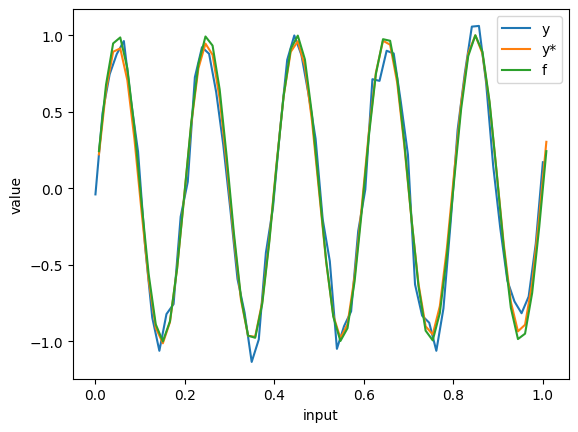

In [ ]:
def gp(theta, X_star):
  kernel_func = lambda x1, x2: np.sum([theta[i] * kernels[i](x1,x2) for i in range(len(theta))]) +( sigma ** 2 if x1 == x2 else 0)
  K_star = np.array([[kernel_func(x_star, x) for x_star in X_star] for x in X])
  return K_star.T @ np.linalg.inv(K_tot(theta)) @ Y
X_star = X + 1/(2*n)
Y_star = gp(theta, X_star)
plt.plot(X, Y, label='y')
plt.plot(X_star, Y_star, label='y*')
plt.plot(X_star, [f(x) for x in X_star], label='f')
plt.xlabel("input")
plt.ylabel("value")
plt.legend()

Text(0.5, 0, 'x')

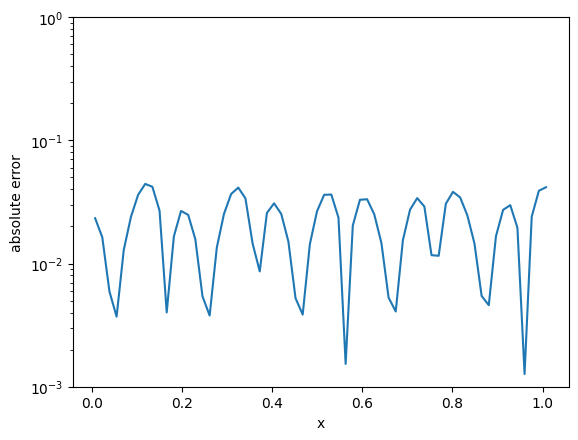

In [ ]:
# error
plt.plot(X_star, abs(Y_star - f(X_star)))
plt.yscale('log')
plt.ylim((1e-3, 1))
plt.ylabel("absolute error")
plt.xlabel("x")

Text(0, 0.5, 'objective function value')

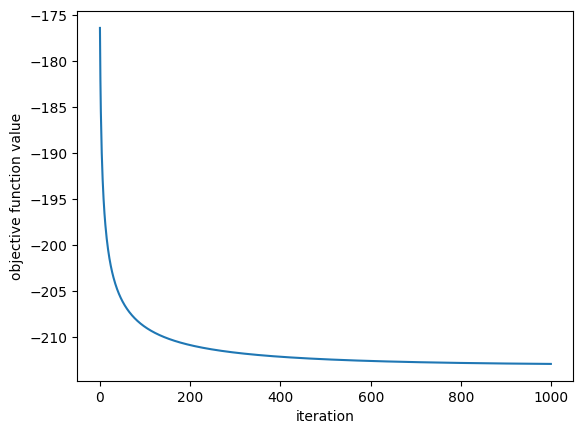

In [ ]:
plt.plot(range(len(obj)), obj)
plt.xlabel("iteration")
plt.ylabel("objective function value")

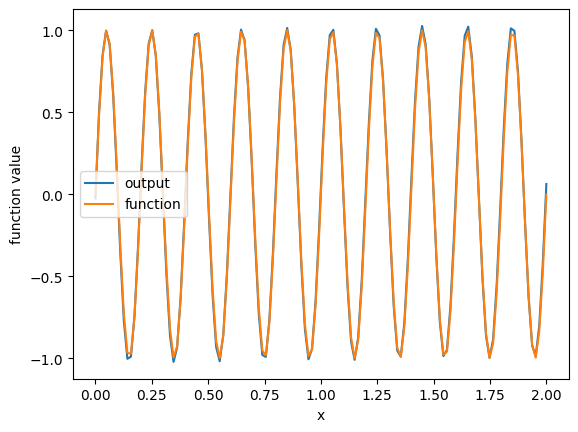

In [ ]:
X_star = np.linspace(0, 2, n*2)
Y_star = gp(theta, X_star)
plt.plot(X_star, Y_star, label='output')
plt.plot(X_star, [f(x) for x in X_star], label='function')
plt.xlabel("x")
plt.ylabel("function value")
plt.legend()

In [ ]:
# The rest of this was me attempting to use cvxpy, however I couldn't convince it that the objective was convex...
p = len(K)
theta = cp.Variable(p, nonneg=True)

K_tot = np.sum([theta[i] * K[i] for i in range(p)])
# print(cp.inv_pos(K_tot).is_dcp())
# print(cp.log_det(K_tot).is_dcp())
K_tot_inv = cp.inv_pos(K_tot)
K_tot_inv.is_psd = True
print(K_tot_inv.is_psd)
print(cp.quad_form(Y, K_tot_inv, assume_PSD=True).is_dcp)
objective_function = cp.log_det(K_tot) + cp.quad_form(Y, cp.inv_pos(K_tot))

constraints = [theta[i] >= 0 for i in range(p)]
constraints.append(K_tot >> 0)
objective = cp.Minimize(objective_function)
problem = cp.Problem(objective, constraints)
problem.solve()
# objective_function

True
<bound method Expression.is_dcp of Expression(UNKNOWN, UNKNOWN, ())>


DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
[-0.00601645  0.49914053  0.87772272  1.04854828  0.98391368  0.67942649
  0.22300826 -0.24333019 -0.62266248 -0.84409894 -0.79660709 -0.54868488
 -0.09535187  0.41805024  0.86904829  1.16846367  1.24344619  1.09229242
  0.71474428  0.25788137 -0.2076191  -0.54008749 -0.63605875 -0.53624277
 -0.17922487  0.2921092   0.81121401  1.2115032   1.43566609  1.43422684
  1.15517059  0.71890115  0.2622077  -0.17043848 -0.40028332 -0.4452949
 -0.20517315  0.16942691  0.70275916  1.1909462   1.52100317  1.6365572
  1.5252172   1.19793842  0.75310512  0.27860745 -0.07965497 -0.26636385
 -0.16818756  0.13352793  0.58651116  1.10507049  1.55697695  1.81549289
  1.82065817  1.62216181  1.22096903  0.74918165  0.30965689  0.03699965
 -0.06520455  0.13941803  0.4760186   1.00676191] @ power(Promote(var4492[0], (64, 64)) @ [[1.00 0.99 ... 0.02 0.02]
 [0.99 1.00 ... 0.03 0.02]
 ...
 [0.02 0.03 ... 1.00 0.99]
 [0.02 0.02 ... 0.99 1.00]] + Promote(var4492[1], (64, 64)) @ [[1.50 1.48 ... 0.52 0.50]
 [1.48 1.47 ... 0.52 0.50]
 ...
 [0.52 0.52 ... 0.50 0.50]
 [0.50 0.50 ... 0.50 0.50]] + Promote(var4492[2], (64, 64)) @ [[1.00 0.00 ... 0.00 1.00]
 [0.00 1.00 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 1.00 0.00]
 [1.00 0.00 ... 0.00 1.00]] + Promote(var4492[3], (64, 64)) @ [[1.00 0.98 ... 0.00 0.00]
 [0.98 1.00 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 1.00 0.98]
 [0.00 0.00 ... 0.98 1.00]], -1.0)